In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
height, width = 128, 128

[8, 6]
[(58, 20, 28, 28), (16, 57, 28, 28)]


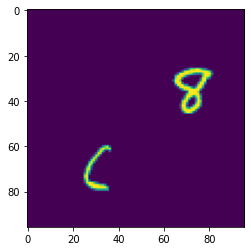

In [ ]:
def make_img(x_array, y_array, height, width):
  new_img = np.zeros([height, width])
  mask = np.zeros([height, width])
  old_height = x_array.shape[1]
  old_width = x_array.shape[2]
  all_num = 2
  num = 0
  labels = []
  shifts = []
  while num < all_num:
    x_shift = random.randint(0, width-old_width)
    y_shift = random.randint(0, width-old_height)
    idx = random.randint(0, x_array.shape[0]-1)
    if (mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height]==0).all():
      new_img[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = x_array[idx]
      mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = 1
      labels.append(y_array[idx])
      shifts.append((x_shift, y_shift, 28, 28))
      num +=1
  return new_img, labels, shifts

s = make_img(x_train, y_train, height, width)
plt.imshow(s[0])
print(s[1])
print(s[2])
#plt.gca().add_patch(matplotlib.patches.Rectangle((s[2][0]),28,28, ec='r', fc='none'))

In [ ]:
imgs = []
labels = []
for i in tqdm(range(40000)):
  sample = make_img(x_train, y_train, height, width)
  imgs.append(sample[0])
  labels.append(sample[2])

100%|██████████| 40000/40000 [00:04<00:00, 8125.53it/s]


In [ ]:
#height, width = 128, 128
print(((size+2*padding)+stride*10))
big_padding = 4
stride = 10
size = 28
padding = 4
#chcemy powiększyć okno o padding i odjąć rozmiar okna
n_rows = (height-size-(2*padding))/stride
n_cols = (width-size-(2*padding))/stride

136


In [ ]:
h = size/2+padding+stride*row
w = size/2+padding+stride*column
def kardashian_dist(labels, h, w):
    

In [ ]:
def step(X, y):
    for row in range(n_rows):
        for column in range(n_cols):
            h = size/2+padding+stride*row
            w = size/2+padding+stride*column
            
            with tf.GradientTape() as tape:

                pred = model(X)[0]
                loss = cat_loss(y, pred)
                if 

                grads = tape.gradient(loss, model.trainable_variables)
                opt.apply_gradients(zip(grads, model.trainable_variables))

#kiedy jest cyfra
    cyfry powinny być posortowane
    jeśli współrzędne są w kwadracie dodaj właściwy label
    predykcja confidence
    strata dla regresji powinna być mała
    klasyfikacja


#kiedy nie ma cyfry
    współrzędne nie są w kwadracie dodaj random label
    predykcja confidence
    nie liczymy straty regresji i klasyfikacji

In [ ]:
imgs = np.array(imgs)
labels = np.array(labels)

In [ ]:
imgs = imgs/255

In [ ]:
labels = labels.reshape(40000, -1)

In [ ]:
imgs = imgs.reshape(40000,96,96,1)

In [ ]:
labels.shape

(40000, 8)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten

inp = Input([96,96,1])
x = inp
x = Conv2D(16, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(8, activation="linear")(x)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0     

In [ ]:
#model.fit(imgs, labels, epochs=5, batch_size=64)

In [ ]:
model.predict(imgs[1].reshape(1,96,96,1))

array([[-0.01725834,  0.00448811,  0.01047117, -0.03446294, -0.0052368 ,
         0.01385983, -0.02138148, -0.01389986]], dtype=float32)

In [ ]:
labels[1]

array([47,  8, 28, 28, 12, 18, 28, 28])